In [ ]:
import math
import random
import os

from app_settings import set_random_seed,set_global_settings
set_random_seed()
set_global_settings()



from pypinyin import pinyin, Style
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from IPython.display import display, Javascript
import tensorflow as tf
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import spearmanr
from UCBCapstone_data_io import *
from UCBCapstone_data_prepare import *
from UCBCapstone_data_view import *
from UCBCapstone_models import *
from UCBCapstone_backtest import *



%load_ext autoreload
%autoreload 2


2025-07-20 13:06:22.818510: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-20 13:06:22.832304: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753041982.846700  209183 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753041982.850196  209183 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753041982.860390  209183 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### Notebook introduction:
- This notebook presents data explore results of the data.
    - The finding here will be used by another 2 notebooks for modeling and backtrader test
- Here is the outline of this notebook:
    - Data load and preview for one index future contact product
    - Correlation and IC analysis between future contract trading data and CSI index change next day ( X and y for model training)
        - Correlation and IC analysis between contract trading data from top traders


### Data loading and data preview

In [12]:
product='IC'
df_index_future, df_future_trading, df_index =read_all(product)



510500.SS already exists, skip downloading...


### Show the raw data for index future daily data which reflects the whole market for a particular index future product. 
    - Note, this is **different** from top dealer based index future trading data which offers a different view of future trading

In [13]:
df_index_future.head(1)

,Contract,Open,High,Low,Volume,Amount,OpenInterest,OpenInterestChange,Close,SettlementPrice,LastSettlementPrice,Change1,Change2,Delta
datetime,,,,,,,,,,,,,,
2020-01-02,IC2001,5300.0,5392.4,5281.0,68331,7312402.38,75083.0,2008.0,5361.8,5368.8,5266.8,95.0,102.0,--


In [14]:
df_index.head(1)

,Close,High,Low,Open,Volume
Date,,,,,
2020-01-02,4.914858,4.927542,4.83793,4.860752,269832060


In [15]:
df_future_trading.head()

,dealer,volume,volchange,buyvol,buyvolchange,sellvol,sellvolchange,net_vol_diff
datetime,,,,,,,,
2021-01-04,yideqihuo,2853.0,2664.0,0.0,0.0,0.0,0.0,0
2021-01-04,shanghaidongzheng,8644.0,65.0,9300.0,-166.0,8135.0,-558.0,392
2021-01-04,shanghaizhongqi,449.0,-14.0,0.0,0.0,0.0,0.0,0
2021-01-04,dongxingqihuo,5023.0,-52.0,3636.0,24.0,2284.0,292.0,-268
2021-01-04,dongwuqihuo,0.0,0.0,0.0,0.0,1574.0,35.0,-35


### Data understanding
- df_future_trading:
    - Contains trading information of top 20 traders in each category reported
    - The analysis below intends to find what might be useful for data modeling later
- 

### Data prepare
    - Add technical indicators

In [16]:
df_index= add_technical_indicators(df_index)
df_index= add_technical_return(df_index)

df_index.head(2)

,Close,High,Low,Open,Volume,SMA_20,SMA_50,RSI,MACD,Signal,Histogram,Bollinger_High,Bollinger_Low,Return
Date,,,,,,,,,,,,,,
2020-01-02,4.914858,4.927542,4.837930,4.860752,269832060,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
2020-01-03,4.923310,4.941910,4.903025,4.914015,176955991,NaN,NaN,99.999998,0.000674,0.000135,0.000539,NaN,NaN,0.00172


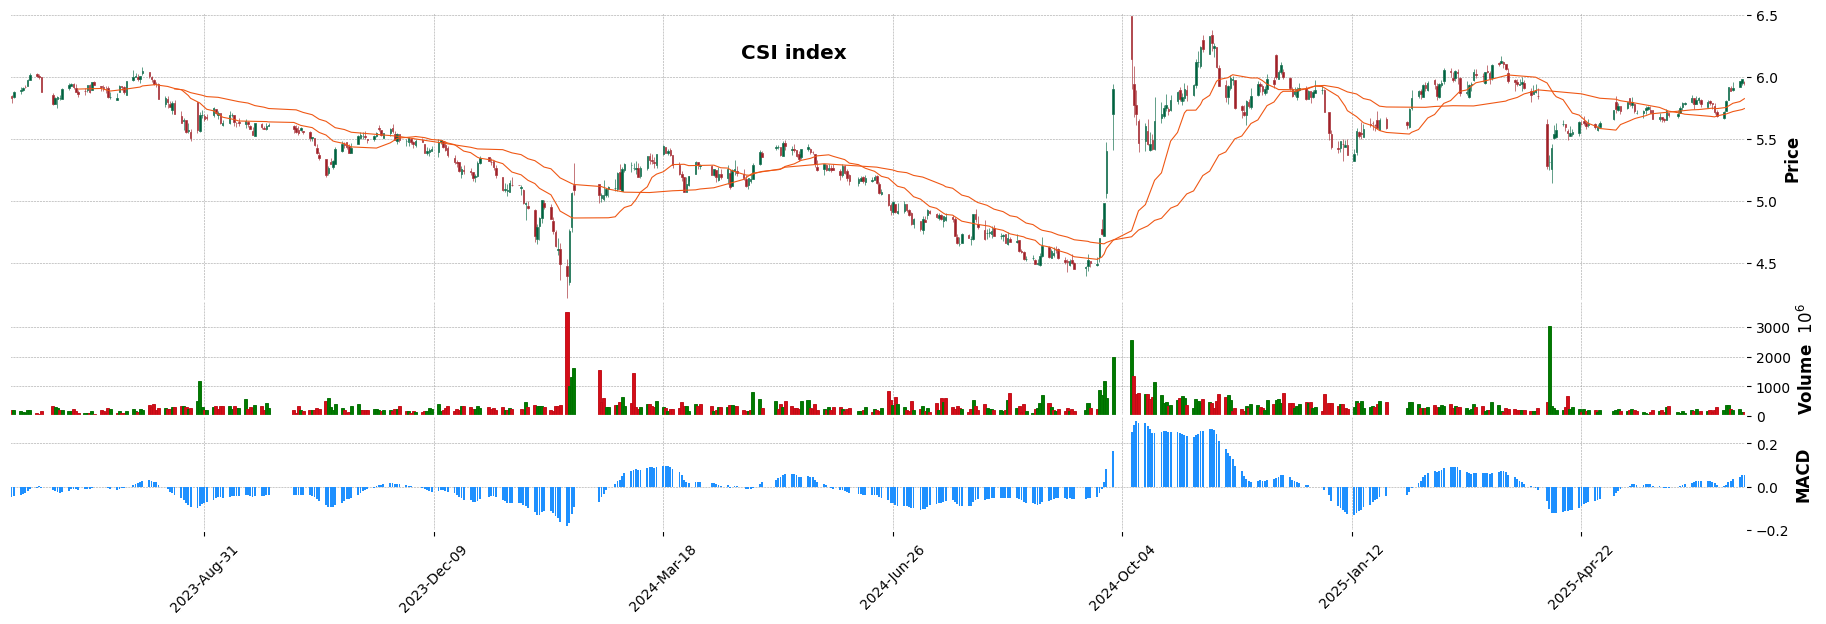

In [118]:
plot_csi_index(df_index)

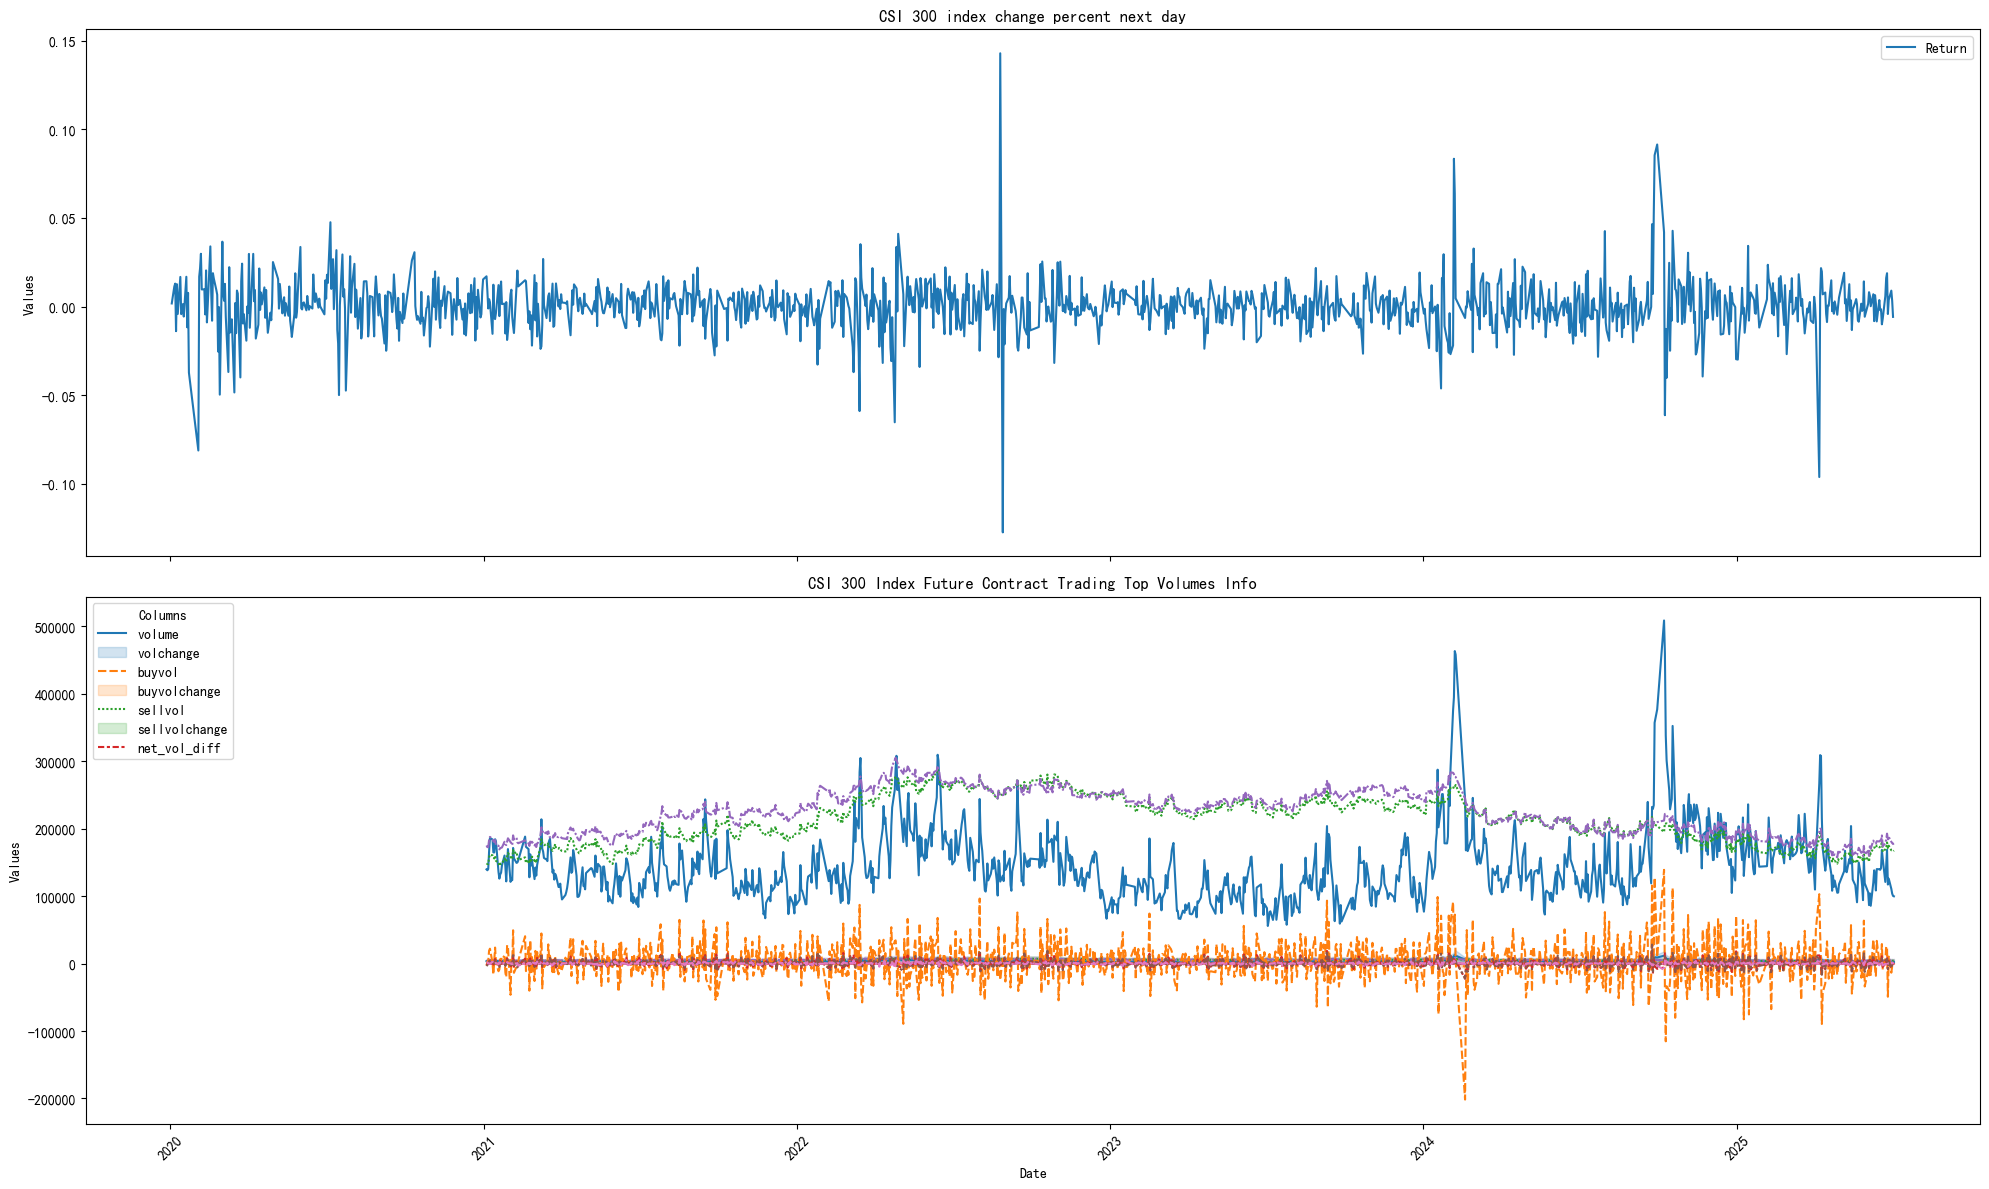

In [17]:
df_future_trading_by_date= group_future_trading_by_date(df_future_trading)
#print(df_future_trading_by_date.head(2))
plot_future_trading(df_index, df_future_trading,df_future_trading_by_date)

### Correlation and IC analysis between future contract trading data and CSI index change next day


#### The following analysis shows that
- Top 50 dealers contribute to 97.24% of total trading volume
- Top 100 dealers contribute to 99.73% of total trading volume

- Top 50 dealers will be more analysis in this notebook.

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38692 entries, 2021-01-04 to 2025-07-03
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   dealer         38692 non-null  object 
 1   volume         38692 non-null  float64
 2   volchange      38692 non-null  float64
 3   buyvol         38692 non-null  float64
 4   buyvolchange   38692 non-null  float64
 5   sellvol        38692 non-null  float64
 6   sellvolchange  38692 non-null  float64
 7   net_vol_diff   38692 non-null  int64  
dtypes: float64(6), int64(1), object(1)
memory usage: 2.7+ MB
None


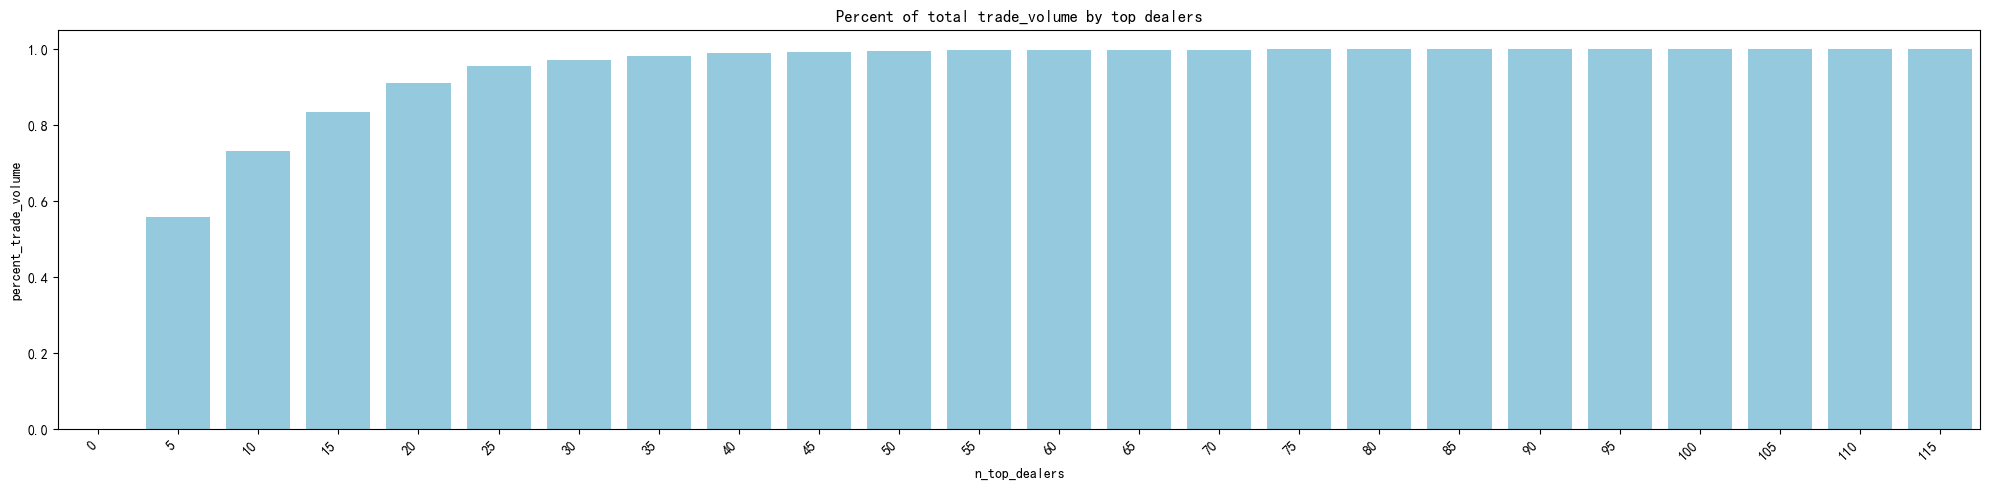

In [18]:
df_vol_percent=get_total_trade_vol_top_dealers(df_future_trading) 
plot_one(df_vol_percent,'barplot',x_col='n_top_dealers', y_col='percent_trade_volume', title='Percent of total trade_volume by top dealers', color='skyblue')
df_future_top=get_idx_future_top_traders(df_future_trading,50)
top_dealers=df_future_top['dealer'].unique()
print(df_future_top.info())


#### Find out the Information Coefficient (IC) between different future data columns of all dealers and CSI index change next data.
    - IF future contract volume seem to have highest IC with CSI index change next day
    - The future contract trading volume change has highest IC with CSI index change next day. Future contact buy volume and sell volume have high IC as well.
    - Surprisingly, the net trade volume has very small IC with the  CSI index change next day

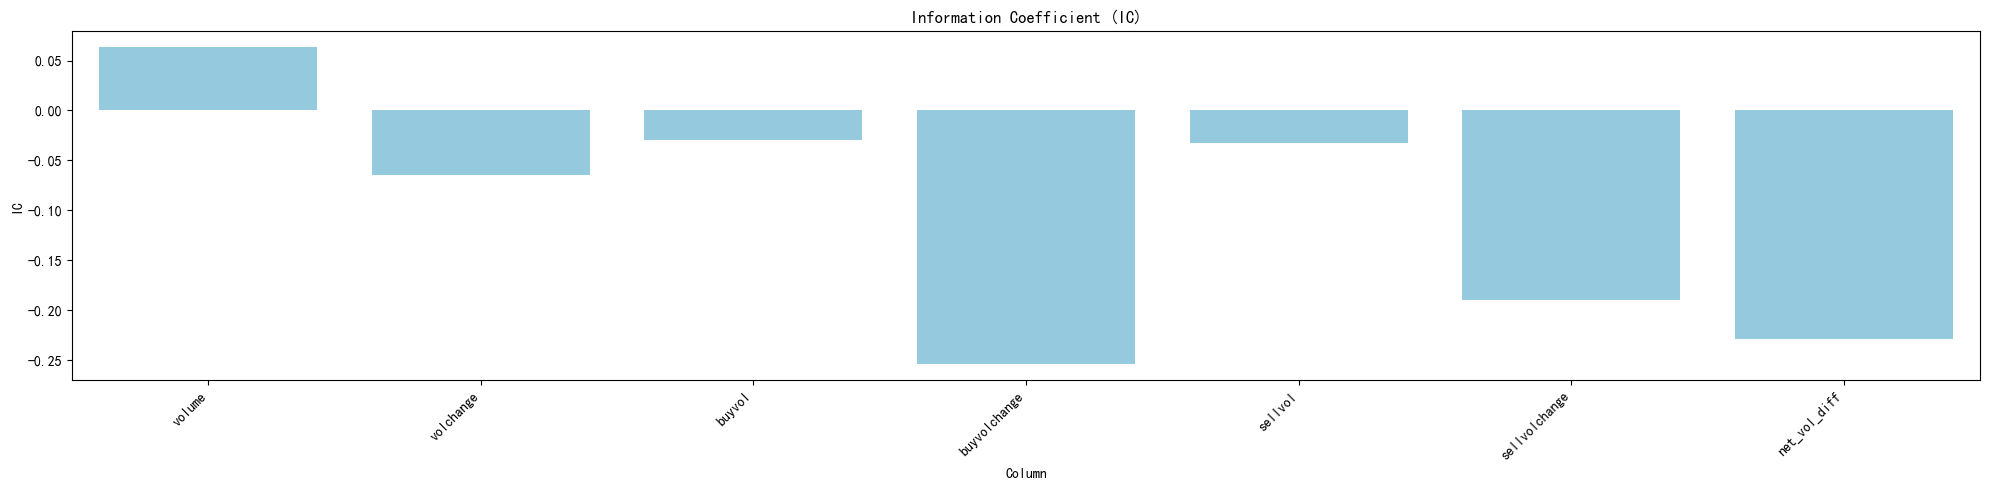

In [19]:
df_ic = cal_IC(df_index, df_future_top)
plot_one(df_ic,'barplot',x_col='Column', y_col='IC', title='Information Coefficient (IC)', color='skyblue')

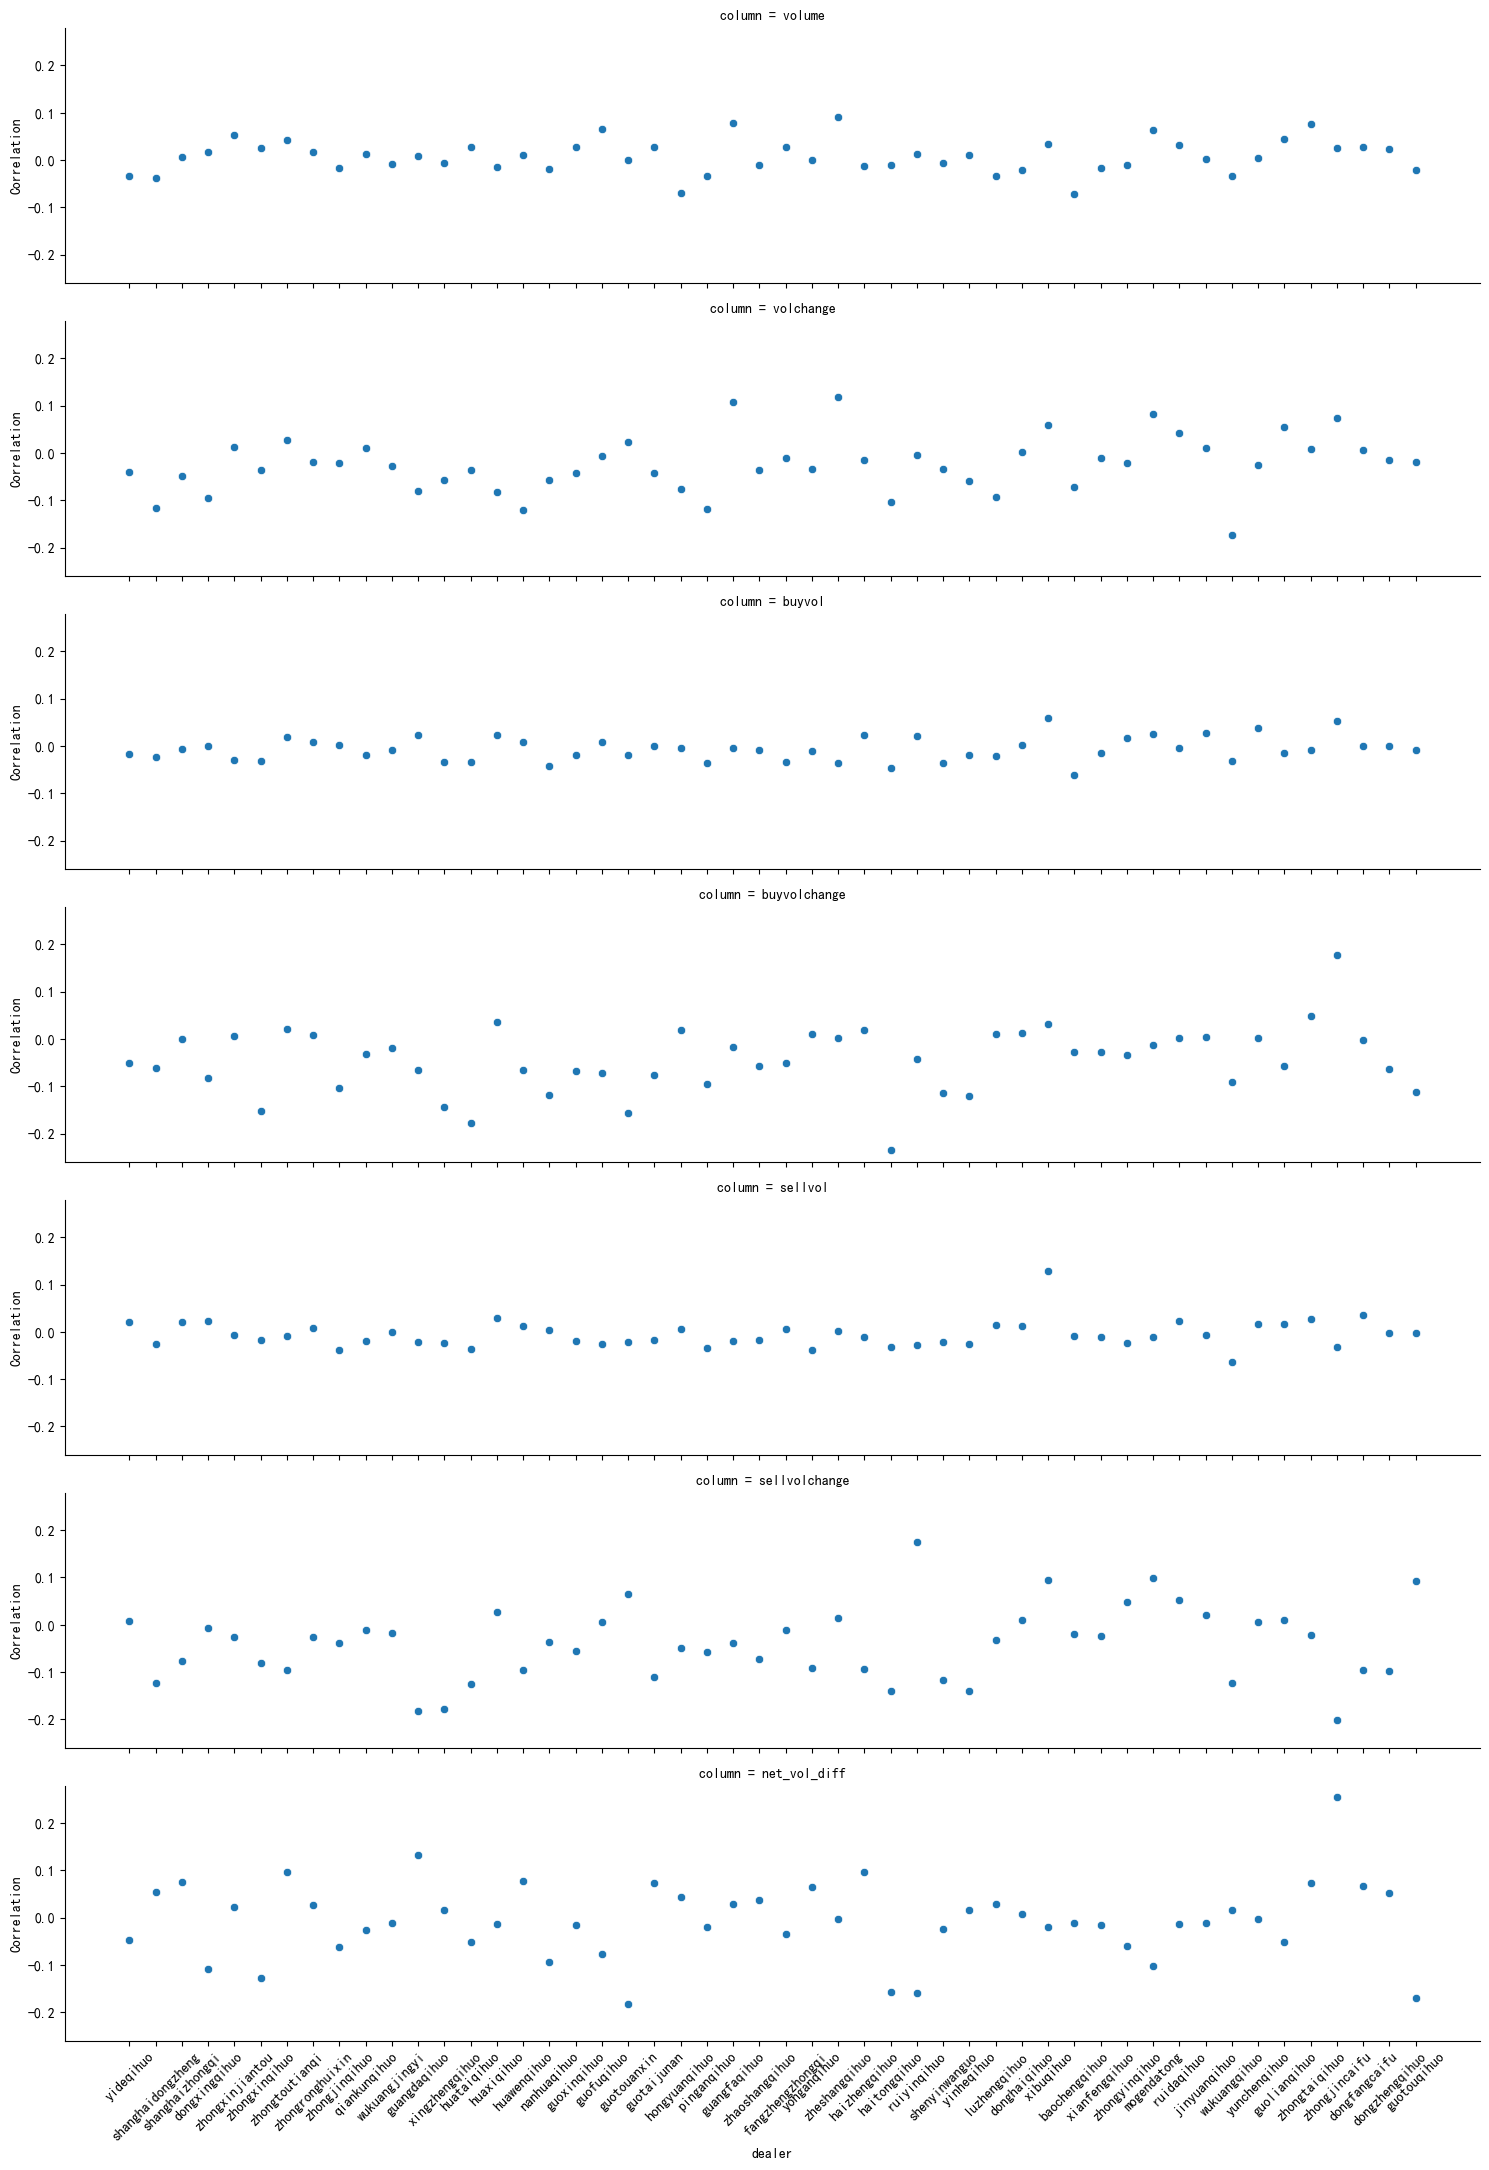

In [20]:
df_corr=cal_corr(df_index, df_future_top)

g=sns.relplot(
    data=df_corr, 
    x="dealer", y="Correlation", row='column', facet_kws={'sharex': True}, height=3,aspect=5,

)


for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=45, labelright=True)

### Zoom in to see the correlation between future contract volume and CSI index change next day
    - those will highest future contract volume don't have the highest correlation 

/tmp/ipykernel_225599/4010687043.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr_by_vol['Abs_Correlation'] =abs(df_corr_by_vol['Correlation'])


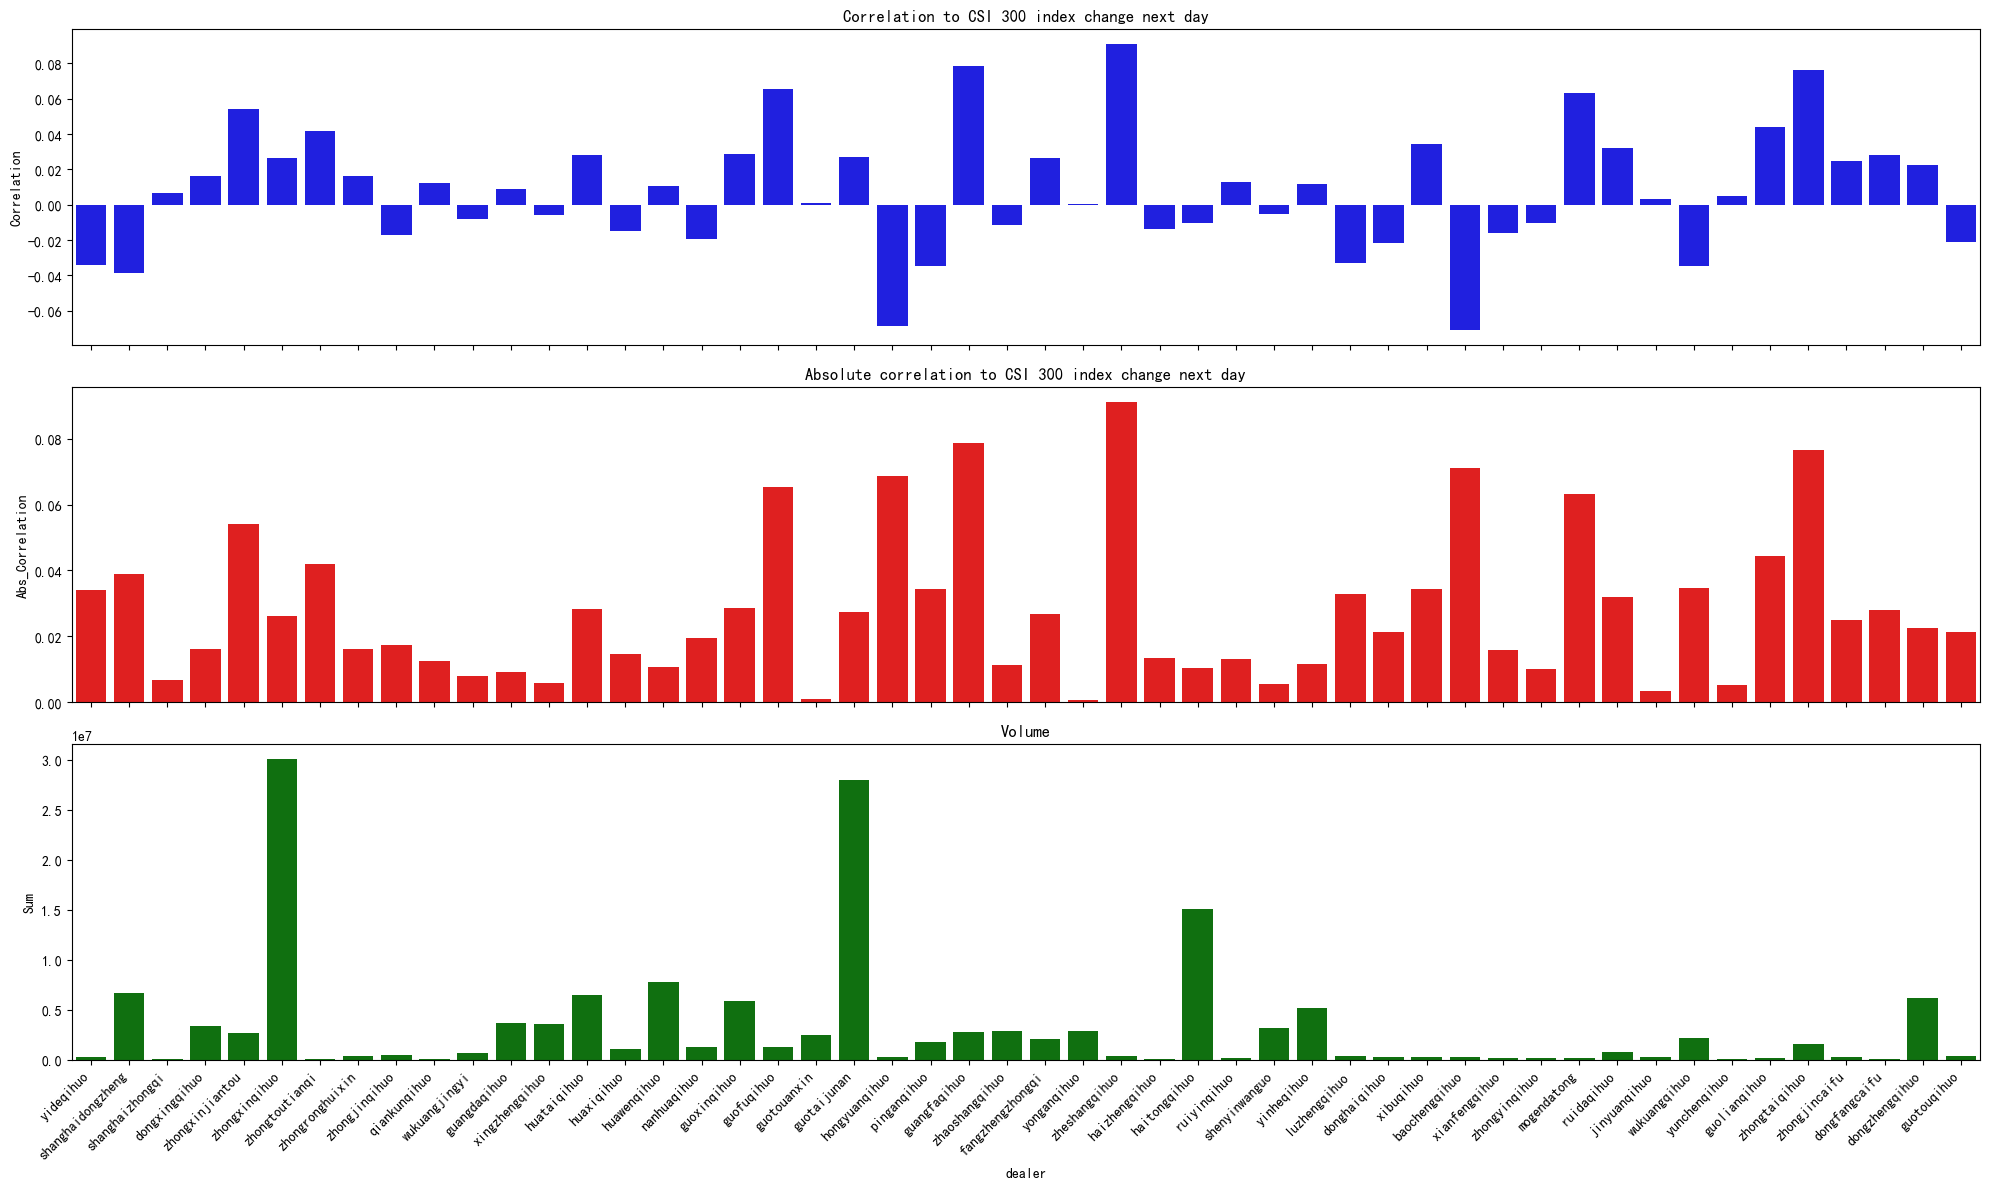

In [21]:
df_corr_by_vol= df_corr[df_corr['column']=='volume']
df_corr_by_vol['Abs_Correlation'] =abs(df_corr_by_vol['Correlation'])

plot_n(df_corr_by_vol,n=3, x_col='dealer', y_cols=['Correlation','Abs_Correlation','Sum'],titles=['Correlation to CSI 300 index change next day','Absolute correlation to CSI 300 index change next day','Volume'], colors=['blue','red','green'])
